# Proyecto Final IA 1 - Juego Ping Pong

Imports: bibliotecas usadas para el entorno (pygame), cálculo (numpy), gráficos (matplotlib), y utilidades (pickle, os).

In [1]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from collections import defaultdict
import sys

pygame 2.1.3.dev8 (SDL 2.32.56, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


Configuración: parámetros del juego (tamaño de ventana, colores, paletas y física de la pelota).

In [ ]:
# Inicializar pygame antes de cualquier cosa
os.environ['SDL_VIDEO_WINDOW_POS'] = "%d,%d" % (100, 100)

# Configuración del juego
ANCHO = 1000
ALTO = 600
FPS = 60

# Colores
BLANCO = (255, 255, 255)
NEGRO = (0, 0, 0)
ROJO = (255, 50, 50)
AZUL_CLARO = (100, 200, 255)
VERDE = (50, 255, 50)
AMARILLO = (255, 255, 100)
NARANJA = (255, 165, 0)

# Configuración de las paletas
PALETA_ANCHO = 15
PALETA_ALTO = 80
PALETA_VELOCIDAD = 6

# Configuración de la pelota
PELOTA_TAMAÑO = 12
PELOTA_VEL_X = 6
PELOTA_VEL_Y = 6
PELOTA_VEL_BOOST = 80 # Velocidad al ser empujada con fuerza

# Configuración de empuje
COOLDOWN_EMPUJE = 45  # 45 Frames (≈0.75 segundos a 60 FPS) de recarga para volver empujar

Clase `PongEnvironment`: contiene la lógica del juego, estado, colisiones, empuje, y renderizado.

In [ ]:
class PongEnvironment:
    """Entorno del juego Pong 2v2 con empuje de pelota"""
    
    def __init__(self, render=True):
        self.render_game = render
        if self.render_game:
            try:
                pygame.init()
                pygame.display.init()
                self.screen = pygame.display.set_mode((ANCHO, ALTO))
                pygame.display.set_caption("Pong 2v2 - Q-Learning")
                self.clock = pygame.time.Clock()
                self.font = pygame.font.Font(None, 74)
                self.small_font = pygame.font.Font(None, 28)
                self.tiny_font = pygame.font.Font(None, 20)
                print("Pygame inicializado correctamente")
            except Exception as e:
                print(f"Error al inicializar pygame: {e}")
                print("Continuando sin renderizado...")
                self.render_game = False
        
        self.reset()
    
    def reset(self):
        """Reinicia el entorno a su estado inicial"""
        # Posiciones de las paletas (4 jugadores)
        # Equipo izquierdo (rojo = agente, azul claro = compañero)
        self.paleta_izq1_y = ALTO // 3 - PALETA_ALTO // 2  # Agente (arriba)
        self.paleta_izq2_y = 2 * ALTO // 3 - PALETA_ALTO // 2  # Compañero (abajo)
        
        # Equipo derecho (verde = oponentes IA)
        self.paleta_der1_y = ALTO // 3 - PALETA_ALTO // 2
        self.paleta_der2_y = 2 * ALTO // 3 - PALETA_ALTO // 2
        
        # Posición y velocidad de la pelota
        self.pelota_x = ANCHO // 2
        self.pelota_y = ALTO // 2
        self.pelota_vel_x = PELOTA_VEL_X * np.random.choice([-1, 1])
        self.pelota_vel_y = PELOTA_VEL_Y * np.random.choice([-1, 1])
        self.pelota_empujada = False  # Indicador si pelota fue empujada
        
        # Cooldown para empuje (frames)
        self.cooldown_izq1 = 0
        self.cooldown_izq2 = 0
        self.cooldown_der1 = 0
        self.cooldown_der2 = 0
        
        # Puntuaciones
        self.puntos_izq = 0
        self.puntos_der = 0
        
        return self._get_state()
    
    def _get_state(self):
        """Obtiene el estado discretizado del entorno"""
        # Discretizar posiciones para reducir el espacio de estados
        pelota_x_disc = int(self.pelota_x / (ANCHO / 12))
        pelota_y_disc = int(self.pelota_y / (ALTO / 8))
        paleta_izq1_disc = int(self.paleta_izq1_y / (ALTO / 8))
        paleta_izq2_disc = int(self.paleta_izq2_y / (ALTO / 8))
        
        # Dirección de la pelota
        vel_x_dir = 1 if self.pelota_vel_x > 0 else 0
        vel_y_dir = 1 if self.pelota_vel_y > 0 else 0
        
        # Estado de velocidad de pelota (normal o empujada)
        pelota_rapida = 1 if self.pelota_empujada else 0
        
        # Cooldown disponible (simplificado)
        cooldown_disponible = 1 if self.cooldown_izq1 == 0 else 0
        
        return (pelota_x_disc, pelota_y_disc, paleta_izq1_disc, 
                paleta_izq2_disc, vel_x_dir, vel_y_dir, 
                pelota_rapida, cooldown_disponible)
    
    def _empujar_pelota(self, paleta_y, direccion_x, cooldown_actual):
        """
        Empuja la pelota con fuerza si hay contacto
        direccion_x: 1 para derecha, -1 para izquierda
        """
        # Verificar cooldown
        if cooldown_actual > 0:
            return cooldown_actual, False
        
        # Verificar si la pelota está en contacto con la paleta
        if direccion_x > 0:  # Paleta izquierda
            en_rango_x = self.pelota_x <= PALETA_ANCHO + PELOTA_TAMAÑO
        else:  # Paleta derecha
            en_rango_x = self.pelota_x >= ANCHO - PALETA_ANCHO - PELOTA_TAMAÑO
        
        en_rango_y = paleta_y <= self.pelota_y <= paleta_y + PALETA_ALTO
        
        if en_rango_x and en_rango_y:
            # Empujar con fuerza
            self.pelota_vel_x = PELOTA_VEL_BOOST * direccion_x
            # Añadir componente vertical basado en dónde golpea
            diferencia = (self.pelota_y - (paleta_y + PALETA_ALTO // 2)) / (PALETA_ALTO // 2)
            self.pelota_vel_y = PELOTA_VEL_BOOST * diferencia * 0.7
            self.pelota_empujada = True
            return COOLDOWN_EMPUJE, True
        
        return cooldown_actual, False
    
    def step(self, accion_izq1, accion_izq2, accion_der1, accion_der2):
        """
        Ejecuta un paso en el entorno
        Acciones: 0=quieto, 1=arriba, 2=abajo, 3=empujar, 4=empujar arriba, 5=empujar abajo
        Retorna: (nuevo_estado, recompensa, terminado, info)
        """
        # Reducir cooldowns
        self.cooldown_izq1 = max(0, self.cooldown_izq1 - 1)
        self.cooldown_izq2 = max(0, self.cooldown_izq2 - 1)
        self.cooldown_der1 = max(0, self.cooldown_der1 - 1)
        self.cooldown_der2 = max(0, self.cooldown_der2 - 1)
        
        recompensa = 0
        empuje_exitoso = False
        
        # Mover paleta izquierda 1 (agente) - solo hasta media cancha
        if accion_izq1 == 1 and self.paleta_izq1_y > 0:
            # Mover arriba
            self.paleta_izq1_y -= PALETA_VELOCIDAD
        elif accion_izq1 == 2 and self.paleta_izq1_y < ALTO // 2 - PALETA_ALTO:
            # Mover abajo
            self.paleta_izq1_y += PALETA_VELOCIDAD
        elif accion_izq1 in [3, 4, 5]:  # Empujar
            if accion_izq1 == 4:  # Empujar arriba
                self.paleta_izq1_y = max(0, self.paleta_izq1_y - PALETA_VELOCIDAD)
            elif accion_izq1 == 5:  # Empujar abajo
                self.paleta_izq1_y = min(ALTO // 2 - PALETA_ALTO, self.paleta_izq1_y + PALETA_VELOCIDAD)
            
            self.cooldown_izq1, exitoso = self._empujar_pelota(self.paleta_izq1_y, 1, self.cooldown_izq1)
            if exitoso:
                recompensa += 8
                empuje_exitoso = True
        
        # Mover paleta izquierda 2 (compañero) - solo hasta media cancha
        if accion_izq2 == 1 and self.paleta_izq2_y > ALTO // 2:
            self.paleta_izq2_y -= PALETA_VELOCIDAD
        elif accion_izq2 == 2 and self.paleta_izq2_y < ALTO - PALETA_ALTO:
            self.paleta_izq2_y += PALETA_VELOCIDAD
        elif accion_izq2 in [3, 4, 5]:
            if accion_izq2 == 4:
                self.paleta_izq2_y = max(ALTO // 2, self.paleta_izq2_y - PALETA_VELOCIDAD)
            elif accion_izq2 == 5:
                self.paleta_izq2_y = min(ALTO - PALETA_ALTO, self.paleta_izq2_y + PALETA_VELOCIDAD)
            
            self.cooldown_izq2, exitoso = self._empujar_pelota(
                self.paleta_izq2_y, 1, self.cooldown_izq2)
            if exitoso:
                recompensa += 5
        
        # Mover paleta derecha 1 (oponente) - solo hasta media cancha
        if accion_der1 == 1 and self.paleta_der1_y > 0:
            self.paleta_der1_y -= PALETA_VELOCIDAD
        elif accion_der1 == 2 and self.paleta_der1_y < ALTO // 2 - PALETA_ALTO:
            self.paleta_der1_y += PALETA_VELOCIDAD
        elif accion_der1 in [3, 4, 5]:
            if accion_der1 == 4:
                self.paleta_der1_y = max(0, self.paleta_der1_y - PALETA_VELOCIDAD)
            elif accion_der1 == 5:
                self.paleta_der1_y = min(ALTO // 2 - PALETA_ALTO, self.paleta_der1_y + PALETA_VELOCIDAD)
            
            self.cooldown_der1, exitoso = self._empujar_pelota(self.paleta_der1_y, -1, self.cooldown_der1)
            if exitoso and empuje_exitoso:
                recompensa -= 3  # Penalización leve si ambos empujan
        
        # Mover paleta derecha 2 (oponente) - solo hasta media cancha
        if accion_der2 == 1 and self.paleta_der2_y > ALTO // 2:
            self.paleta_der2_y -= PALETA_VELOCIDAD
        elif accion_der2 == 2 and self.paleta_der2_y < ALTO - PALETA_ALTO:
            self.paleta_der2_y += PALETA_VELOCIDAD
        elif accion_der2 in [3, 4, 5]:
            if accion_der2 == 4:
                self.paleta_der2_y = max(ALTO // 2, self.paleta_der2_y - PALETA_VELOCIDAD)
            elif accion_der2 == 5:
                self.paleta_der2_y = min(ALTO - PALETA_ALTO, self.paleta_der2_y + PALETA_VELOCIDAD)
            
            self.cooldown_der2, _ = self._empujar_pelota(self.paleta_der2_y, -1, self.cooldown_der2)
        
        # Mover pelota
        self.pelota_x += self.pelota_vel_x
        self.pelota_y += self.pelota_vel_y
        
        # Reducir velocidad gradualmente si fue empujada
        if self.pelota_empujada:
            if abs(self.pelota_vel_x) > PELOTA_VEL_X:
                self.pelota_vel_x *= 0.95
            else:
                self.pelota_vel_x = PELOTA_VEL_X if self.pelota_vel_x > 0 else -PELOTA_VEL_X
                self.pelota_empujada = False
            
            if abs(self.pelota_vel_y) > PELOTA_VEL_Y:
                self.pelota_vel_y *= 0.95
        
        # Colisión con paredes superior e inferior
        if self.pelota_y <= 0 or self.pelota_y >= ALTO - PELOTA_TAMAÑO:
            self.pelota_vel_y *= -1
            self.pelota_y = max(0, min(ALTO - PELOTA_TAMAÑO, self.pelota_y))
        
        # Colisión con paleta izquierda 1 (agente - parte superior)
        if (self.pelota_x <= PALETA_ANCHO and 
            self.paleta_izq1_y <= self.pelota_y <= self.paleta_izq1_y + PALETA_ALTO):
            self.pelota_vel_x *= -1
            self.pelota_x = PALETA_ANCHO
            recompensa += 8
        
        # Colisión con paleta izquierda 2 (compañero - parte inferior)
        if (self.pelota_x <= PALETA_ANCHO and 
            self.paleta_izq2_y <= self.pelota_y <= self.paleta_izq2_y + PALETA_ALTO):
            self.pelota_vel_x *= -1
            self.pelota_x = PALETA_ANCHO
            recompensa += 1
        
        # Colisión con paleta derecha 1 (parte superior)
        if (self.pelota_x >= ANCHO - PALETA_ANCHO - PELOTA_TAMAÑO and 
            self.paleta_der1_y <= self.pelota_y <= self.paleta_der1_y + PALETA_ALTO):
            self.pelota_vel_x *= -1
            self.pelota_x = ANCHO - PALETA_ANCHO - PELOTA_TAMAÑO
        
        # Colisión con paleta derecha 2 (parte inferior)
        if (self.pelota_x >= ANCHO - PALETA_ANCHO - PELOTA_TAMAÑO and 
            self.paleta_der2_y <= self.pelota_y <= self.paleta_der2_y + PALETA_ALTO):
            self.pelota_vel_x *= -1
            self.pelota_x = ANCHO - PALETA_ANCHO - PELOTA_TAMAÑO
        
        # Punto para el equipo derecho (malo para el agente)
        if self.pelota_x < 0:
            self.puntos_der += 1
            recompensa -= 15x
            self.pelota_x = ANCHO // 2
            self.pelota_y = ALTO // 2
            self.pelota_vel_x = PELOTA_VEL_X
            self.pelota_vel_y = PELOTA_VEL_Y * np.random.choice([-1, 1])
            self.pelota_empujada = False
        
        # Punto para el equipo izquierdo (bueno para el agente)
        if self.pelota_x > ANCHO:
            self.puntos_izq += 1
            recompensa += 15
            self.pelota_x = ANCHO // 2
            self.pelota_y = ALTO // 2
            self.pelota_vel_x = -PELOTA_VEL_X
            self.pelota_vel_y = PELOTA_VEL_Y * np.random.choice([-1, 1])
            self.pelota_empujada = False
        
        # Terminar episodio si alguien llega a 7 puntos
        terminado = False
        if self.puntos_izq >= 7 or self.puntos_der >= 7:
            terminado = True
            if self.puntos_izq > self.puntos_der:
                recompensa += 20
            else:
                recompensa -= 20
        
        nuevo_estado = self._get_state()
        info = {'puntos_izq': self.puntos_izq, 'puntos_der': self.puntos_der}
        
        return nuevo_estado, recompensa, terminado, info
    
    def render(self):
        """Renderiza el juego"""
        if not self.render_game:
            return
        
        self.screen.fill(NEGRO)
        
        # Dibujar línea central
        pygame.draw.line(self.screen, BLANCO, (ANCHO // 2, 0), 
                        (ANCHO // 2, ALTO), 3)
        
        # Dibujar línea horizontal (media cancha)
        pygame.draw.line(self.screen, (100, 100, 100), (0, ALTO // 2), 
                        (ANCHO, ALTO // 2), 2)
        
        # Dibujar paletas izquierdas (agente en rojo, compañero en azul claro)
        # Resaltar si el empuje está disponible
        color_izq1 = NARANJA if self.cooldown_izq1 == 0 and self.pelota_x < ANCHO // 3 else ROJO
        color_izq2 = NARANJA if self.cooldown_izq2 == 0 and self.pelota_x < ANCHO // 3 else AZUL_CLARO
        
        pygame.draw.rect(self.screen, color_izq1, 
                        (0, self.paleta_izq1_y, PALETA_ANCHO, PALETA_ALTO))
        pygame.draw.rect(self.screen, color_izq2, 
                        (0, self.paleta_izq2_y, PALETA_ANCHO, PALETA_ALTO))
        
        # Dibujar paletas derechas (oponentes en verde)
        pygame.draw.rect(self.screen, VERDE, 
                        (ANCHO - PALETA_ANCHO, self.paleta_der1_y, 
                         PALETA_ANCHO, PALETA_ALTO))
        pygame.draw.rect(self.screen, VERDE, 
                        (ANCHO - PALETA_ANCHO, self.paleta_der2_y, 
                         PALETA_ANCHO, PALETA_ALTO))
        
        # Dibujar pelota (color diferente si está empujada)
        color_pelota = AMARILLO if self.pelota_empujada else BLANCO
        pygame.draw.rect(self.screen, color_pelota, 
                        (self.pelota_x, self.pelota_y, 
                         PELOTA_TAMAÑO, PELOTA_TAMAÑO))
        
        # Mostrar puntuación
        texto_izq = self.font.render(str(self.puntos_izq), True, BLANCO)
        texto_der = self.font.render(str(self.puntos_der), True, BLANCO)
        self.screen.blit(texto_izq, (ANCHO // 4, 20))
        self.screen.blit(texto_der, (3 * ANCHO // 4, 20))
        
        # Mostrar etiquetas
        label_agente = self.small_font.render("AGENTE (RL)", True, ROJO)
        label_companero = self.small_font.render("COMPAÑERO", True, AZUL_CLARO)
        self.screen.blit(label_agente, (30, 10))
        self.screen.blit(label_companero, (30, ALTO - 30))
        
        # Mostrar cooldowns
        if self.cooldown_izq1 > 0:
            cd_text = self.tiny_font.render(f"CD: {self.cooldown_izq1}", True, BLANCO)
            self.screen.blit(cd_text, (30, 40))
        else:
            ready_text = self.tiny_font.render("EMPUJE LISTO!", True, NARANJA)
            self.screen.blit(ready_text, (30, 40))
        
        if self.cooldown_izq2 > 0:
            cd_text = self.tiny_font.render(f"CD: {self.cooldown_izq2}", True, BLANCO)
            self.screen.blit(cd_text, (30, ALTO - 50))
        
        pygame.display.flip()
        self.clock.tick(FPS)
    
    def close(self):
        """Cierra el entorno"""
        if self.render_game:
            pygame.quit()

Clase `QLearningAgent`: implementa la tabla Q, política epsilon-greedy, actualización y persistencia de la Q-table.

In [20]:
class QLearningAgent:
    """Agente de Q-Learning con 6 acciones"""
    
    def __init__(self, n_acciones=6, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.01):
        self.n_acciones = n_acciones
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.q_table = defaultdict(lambda: np.zeros(n_acciones))
    
    def elegir_accion(self, estado, entrenar=True):
        """Política epsilon-greedy"""
        if entrenar and np.random.random() < self.epsilon:
            return np.random.randint(self.n_acciones)
        else:
            return np.argmax(self.q_table[estado])
    
    def actualizar(self, estado, accion, recompensa, nuevo_estado, terminado):
        """Actualiza la tabla Q"""
        q_actual = self.q_table[estado][accion]
        
        if terminado:
            q_objetivo = recompensa
        else:
            q_max_siguiente = np.max(self.q_table[nuevo_estado])
            q_objetivo = recompensa + self.gamma * q_max_siguiente
        
        self.q_table[estado][accion] = q_actual + self.alpha * (q_objetivo - q_actual)
    
    def decaer_epsilon(self):
        """Reduce epsilon"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def guardar(self, filename='q_table_2v2.pkl'):
        """Guarda la tabla Q"""
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print(f"Tabla Q guardada en {filename}")
    
    def cargar(self, filename='q_table_2v2.pkl'):
        """Carga la tabla Q"""
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                self.q_table = defaultdict(lambda: np.zeros(self.n_acciones), 
                                          pickle.load(f))
            print(f"Tabla Q cargada desde {filename}")
        else:
            print(f"Archivo {filename} no encontrado")


def oponente_avanzado(pelota_x, pelota_y, paleta_y, lado, pelota_vel_x, cooldown):
    """
    Oponente avanzado con estrategia de empuje
    Retorna: acción (0-5)
    """
    centro_paleta = paleta_y + PALETA_ALTO // 2
    
    # Decidir si empujar (cuando pelota está cerca y viniendo hacia él)
    if cooldown == 0:
        if lado == 'izq' and pelota_x < 150 and pelota_vel_x < 0:
            if np.random.random() < 0.50:  # 50% de probabilidad
                if abs(pelota_y - centro_paleta) < 25:
                    return 3  # Empujar recto
                elif pelota_y < centro_paleta:
                    return 4  # Empujar arriba
                else:
                    return 5  # Empujar abajo
        elif lado == 'der' and pelota_x > ANCHO - 150 and pelota_vel_x > 0:
            if np.random.random() < 0.50:
                if abs(pelota_y - centro_paleta) < 25:
                    return 3
                elif pelota_y < centro_paleta:
                    return 4
                else:
                    return 5
    
    # Seguir la pelota
    if pelota_y < centro_paleta - 25:
        return 1  # Arriba
    elif pelota_y > centro_paleta + 25:
        return 2  # Abajo
    else:
        return 0  # Quieto


def entrenar(n_episodios=2000, render=False):
    """Entrena al agente en modo 2v2"""
    env = PongEnvironment(render=render)
    agente = QLearningAgent()
    
    recompensas_totales = []
    
    print("Iniciando entrenamiento 2v2...")
    print("Agente (ROJO) + Compañero IA (AZUL) vs 2 Oponentes (VERDE)")
    print("Las paletas brillan en NARANJA cuando el empuje está disponible")
    
    for episodio in range(n_episodios):
        estado = env.reset()
        recompensa_episodio = 0
        terminado = False
        
        while not terminado:
            if render:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        env.close()
                        return
            
            # Agente elige acción
            accion_agente = agente.elegir_accion(estado)
            
            # Compañero elige acción
            accion_companero = oponente_avanzado(
                env.pelota_x, env.pelota_y, env.paleta_izq2_y, 
                'izq', env.pelota_vel_x, env.cooldown_izq2)
            
            # Oponentes eligen acciones
            accion_oponente1 = oponente_avanzado(
                env.pelota_x, env.pelota_y, env.paleta_der1_y, 
                'der', env.pelota_vel_x, env.cooldown_der1)
            accion_oponente2 = oponente_avanzado(
                env.pelota_x, env.pelota_y, env.paleta_der2_y, 
                'der', env.pelota_vel_x, env.cooldown_der2)
            
            # Ejecutar acción en el entorno
            nuevo_estado, recompensa, terminado, info = env.step(
                accion_agente, accion_companero, 
                accion_oponente1, accion_oponente2)
            
            # Actualizar Q-table
            agente.actualizar(estado, accion_agente, recompensa, 
                            nuevo_estado, terminado)
            
            recompensa_episodio += recompensa
            estado = nuevo_estado
            
            if render:
                env.render()
        
        agente.decaer_epsilon()
        recompensas_totales.append(recompensa_episodio)
        
        if (episodio + 1) % 100 == 0:
            promedio_recompensa = np.mean(recompensas_totales[-100:])
            victorias = sum(1 for i in range(max(0, len(recompensas_totales)-100), 
                          len(recompensas_totales)) 
                          if recompensas_totales[i] > 0)
            print(f"Episodio {episodio + 1}/{n_episodios} | "
                  f"Recompensa: {promedio_recompensa:.2f} | "
                  f"Victorias: {victorias}/100 | "
                  f"Epsilon: {agente.epsilon:.4f}")
    
    env.close()
    agente.guardar()
    return agente, recompensas_totales


def jugar(agente=None, n_partidas=5, modo_humano=False):
    """
    Juega partidas 2v2 con el agente entrenado
    modo_humano: Si True, el jugador controla el compañero (paleta azul)
    """
    env = PongEnvironment(render=True)
    
    if agente is None:
        agente = QLearningAgent()
        agente.cargar()
    
    if modo_humano:
        print(f"\n¡MODO COOPERATIVO HABILITADO!")
        print(f"Tú controlas la paleta AZUL CLARO (compañero del agente)")
        print(f"Controles: W/S = Arriba/Abajo, ESPACIO = Empujar")
        print(f"Q/E = Empujar Arriba/Abajo")
        print(f"\nJugando {n_partidas} partidas en equipo con el agente...")
    else:
        print(f"\nJugando {n_partidas} partidas (modo observación)...")
    
    for partida in range(n_partidas):
        estado = env.reset()
        terminado = False
        
        while not terminado:
            # Capturar eventos
            accion_humano = None
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    env.close()
                    return
            
            # Control humano del compañero
            if modo_humano:
                keys = pygame.key.get_pressed()
                if keys[pygame.K_w]:
                    accion_humano = 1  # Arriba
                elif keys[pygame.K_s]:
                    accion_humano = 2  # Abajo
                elif keys[pygame.K_SPACE]:
                    accion_humano = 3  # Empujar
                elif keys[pygame.K_q]:
                    accion_humano = 4  # Empujar arriba
                elif keys[pygame.K_e]:
                    accion_humano = 5  # Empujar abajo
                else:
                    accion_humano = 0  # Quieto
            
            # Agente juega
            accion_agente = agente.elegir_accion(estado, entrenar=False)
            
            # Compañero (humano o IA)
            if modo_humano:
                accion_companero = accion_humano
            else:
                accion_companero = oponente_avanzado(
                    env.pelota_x, env.pelota_y, env.paleta_izq2_y, 
                    'izq', env.pelota_vel_x, env.cooldown_izq2)
            
            # Oponentes
            accion_oponente1 = oponente_avanzado(
                env.pelota_x, env.pelota_y, env.paleta_der1_y, 
                'der', env.pelota_vel_x, env.cooldown_der1)
            accion_oponente2 = oponente_avanzado(
                env.pelota_x, env.pelota_y, env.paleta_der2_y, 
                'der', env.pelota_vel_x, env.cooldown_der2)
            
            nuevo_estado, recompensa, terminado, info = env.step(
                accion_agente, accion_companero,
                accion_oponente1, accion_oponente2)
            
            estado = nuevo_estado
            env.render()
        
        resultado = "VICTORIA" if info['puntos_izq'] > info['puntos_der'] else "DERROTA"
        print(f"Partida {partida + 1}: Equipo Agente {info['puntos_izq']} - "
              f"{info['puntos_der']} Equipo Oponente [{resultado}]")
    
    env.close()

## Entrenamiento con Q-learning

Hiperparámetros: define el número de episodios y parámetros de Q-learning para el entrenamiento.

In [21]:
# Configuración de hiperparámetros para el entrenamiento
HIPERPARAMETROS = {
    'n_episodios': 4000,
    'alpha': 0.1,           # Tasa de aprendizaje
    'gamma': 0.99,          # Factor de descuento
    'epsilon': 1.0,         # Exploración inicial
    'epsilon_decay': 0.9995,  # Decaimiento de epsilon
    'epsilon_min': 0.01,    # Epsilon mínimo
    'render': False         # Visualizar durante entrenamiento
}

print("="*60)
print("CONFIGURACIÓN DE HIPERPARÁMETROS")
print("="*60)
print(f"Episodios: {HIPERPARAMETROS['n_episodios']}")
print(f"Tasa de aprendizaje (alpha): {HIPERPARAMETROS['alpha']}")
print(f"Factor de descuento (gamma): {HIPERPARAMETROS['gamma']}")
print(f"Epsilon inicial: {HIPERPARAMETROS['epsilon']}")
print(f"Decaimiento epsilon: {HIPERPARAMETROS['epsilon_decay']}")
print(f"Epsilon mínimo: {HIPERPARAMETROS['epsilon_min']}")
print("="*60)

# Crear agente con los hiperparámetros configurados
print("\nIniciando entrenamiento con los hiperparámetros especificados...")
agente, recompensas = entrenar(
    n_episodios=HIPERPARAMETROS['n_episodios'],
    render=HIPERPARAMETROS['render']
)

# print("\n¡Entrenamiento completado!")
# recompensas = recompensas_nuevo

CONFIGURACIÓN DE HIPERPARÁMETROS
Episodios: 4000
Tasa de aprendizaje (alpha): 0.1
Factor de descuento (gamma): 0.99
Epsilon inicial: 1.0
Decaimiento epsilon: 0.9995
Epsilon mínimo: 0.01

Iniciando entrenamiento con los hiperparámetros especificados...
Iniciando entrenamiento 2v2...
Agente (ROJO) + Compañero IA (AZUL) vs 2 Oponentes (VERDE)
Las paletas brillan en NARANJA cuando el empuje está disponible
Episodio 100/4000 | Recompensa: 76.53 | Victorias: 74/100 | Epsilon: 0.9512
Episodio 200/4000 | Recompensa: 81.23 | Victorias: 74/100 | Epsilon: 0.9048
Episodio 300/4000 | Recompensa: 77.18 | Victorias: 75/100 | Epsilon: 0.8607
Episodio 400/4000 | Recompensa: 69.74 | Victorias: 68/100 | Epsilon: 0.8187
Episodio 500/4000 | Recompensa: 58.23 | Victorias: 62/100 | Epsilon: 0.7788
Episodio 600/4000 | Recompensa: 77.64 | Victorias: 74/100 | Epsilon: 0.7408
Episodio 700/4000 | Recompensa: 72.05 | Victorias: 68/100 | Epsilon: 0.7046
Episodio 800/4000 | Recompensa: 80.27 | Victorias: 75/100 | Ep

## Evolucion de la Recompensa

Gráficos: muestra la evolución de la recompensa por episodio y su media móvil (ventana 100).

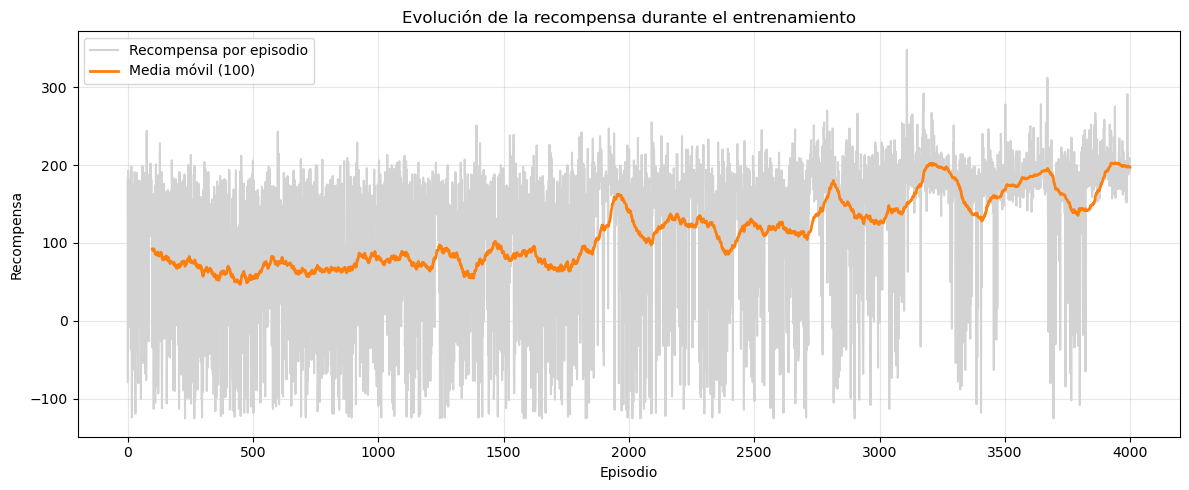

In [15]:
# Grafica la evolución de la recompensa por episodio y su media móvil
rewards = recompensas if 'recompensas' in globals() else []

if len(rewards) == 0:
    print("No hay recompensas para graficar.")
else:
    window = 100  # tamaño de la ventana para la media móvil
    mov_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.plot(rewards, color='lightgray', label='Recompensa por episodio')
    plt.plot(range(window - 1, window - 1 + len(mov_avg)), mov_avg, color='C1',
             linewidth=2, label=f'Media móvil ({window})')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.title('Evolución de la recompensa durante el entrenamiento')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Funciones auxiliares: media móvil y visualización de tasa de victorias (win rate).

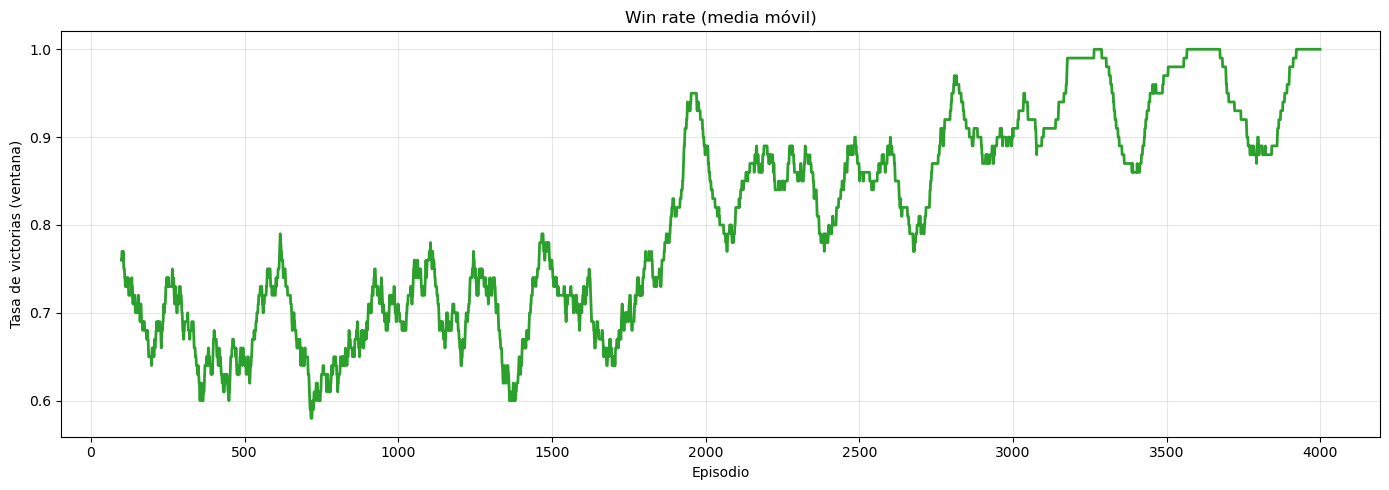

In [16]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w)/w, mode='valid')

# Asumiendo: `recompensas` es lista de recompensas por episodio
window = 100
if len(recompensas) > 0:
    mov_avg = moving_average(recompensas, window)
    wins = (np.array(recompensas) > 0).astype(int)
    win_rate = moving_average(wins, window)

    plt.figure(figsize=(14,5))
    # plt.subplot(1,2,1)
    # plt.plot(recompensas, color='lightgray', label='Recompensa por episodio')
    # plt.plot(range(window-1, window-1+len(mov_avg)), mov_avg, color='C1', linewidth=2, label=f'Media móvil ({window})')
    # plt.xlabel('Episodio'); plt.ylabel('Recompensa'); plt.legend(); plt.grid(alpha=0.3)

    # plt.subplot(1,2,2)
    plt.plot(range(window-1, window-1+len(win_rate)), win_rate, color='C2', linewidth=2)
    plt.xlabel('Episodio'); plt.ylabel('Tasa de victorias (ventana)')
    plt.title('Win rate (media móvil)')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No hay datos de recompensas.")

Evaluación determinista: la función `evaluar_agente` ejecuta partidas con `epsilon=0` para medir rendimiento más estable.

In [8]:
def evaluar_agente(agente, n_partidas=50):
    """Evalúa agente con epsilon=0 (determinista). Devuelve lista de recompensas y victorias."""
    env = PongEnvironment(render=False)
    eps_backup = getattr(agente, 'epsilon', None)
    agente.epsilon = 0.0
    recompensas_eval = []
    victorias = 0
    for _ in range(n_partidas):
        estado = env.reset()
        terminado = False
        recompensa_total = 0
        while not terminado:
            accion = agente.elegir_accion(estado, entrenar=False)
            nuevo_estado, recompensa, terminado, info = env.step(accion, 
                                                                 oponente_avanzado(env.pelota_x, env.pelota_y, env.paleta_izq2_y,'izq',env.pelota_vel_x,env.cooldown_izq2),
                                                                 oponente_avanzado(env.pelota_x, env.pelota_y, env.paleta_der1_y,'der',env.pelota_vel_x,env.cooldown_der1),
                                                                 oponente_avanzado(env.pelota_x, env.pelota_y, env.paleta_der2_y,'der',env.pelota_vel_x,env.cooldown_der2))
            recompensa_total += recompensa
            estado = nuevo_estado
        recompensas_eval.append(recompensa_total)
        if info['puntos_izq'] > info['puntos_der']:
            victorias += 1
    if eps_backup is not None:
        agente.epsilon = eps_backup
    env.close()
    return recompensas_eval, victorias

## Evaluación del modelo

Interfaz: menú interactivo para ver, jugar o evaluar el agente con epsilon 0.

In [18]:
# Menú interactivo para jugar y evaluar el agente
print("="*60)
print("PONG 2v2 CON Q-LEARNING Y MECÁNICA DE EMPUJE")
print("="*60)
print("\nOpciones:")
print("1. Ver al agente jugar (modo observación)")
print("2. Jugar EN EQUIPO con el agente (modo cooperativo)")
print("3. Evaluar agente (50 partidas)(Evaluar de forma determinista (epsilon=0))")
print("="*60)

opcion = input("\nSelecciona una opción (1/2/3): ").strip()

if opcion == "1":
    n = input("¿Cuántas partidas quieres ver? (por defecto 3): ").strip()
    n_partidas = int(n) if n.isdigit() else 3
    jugar(agente, n_partidas=n_partidas, modo_humano=False)

elif opcion == "2":
    n = input("¿Cuántas partidas quieres jugar? (por defecto 5): ").strip()
    n_partidas = int(n) if n.isdigit() else 5
    jugar(agente, n_partidas=n_partidas, modo_humano=True)

elif opcion == "3":
    print("\nEvaluando agente en 50 partidas...")
    recompensas_eval, victorias = evaluar_agente(agente, n_partidas=50)
    print(f"Victorias: {victorias}/50 ({100*victorias/50:.1f}%)")
    print(f"Recompensa promedio: {np.mean(recompensas_eval):.2f}")
    print(f"Recompensa máxima: {np.max(recompensas_eval):.2f}")
    print(f"Recompensa mínima: {np.min(recompensas_eval):.2f}")

else:
    print("Opción no válida.")


PONG 2v2 CON Q-LEARNING Y MECÁNICA DE EMPUJE

Opciones:
1. Ver al agente jugar (modo observación)
2. Jugar EN EQUIPO con el agente (modo cooperativo)
3. Evaluar agente (50 partidas)(Evaluar de forma determinista (epsilon=0))
Pygame inicializado correctamente

Jugando 1 partidas (modo observación)...
Partida 1: Equipo Agente 7 - 0 Equipo Oponente [VICTORIA]
